<a href="https://colab.research.google.com/github/Brennan-Richards/AI-Investment/blob/main/Index_Fund_Future_Value_Prediction_w_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brennan Richards

### Imports

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3MB 13.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=713b7b898f31aa7bdc69c33d4a02d8ab459b95d7d2e8e37067b613315b463c84
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
pip install fredapi

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, f1_score, confusion_matrix, plot_confusion_matrix
import pickle
from joblib import dump, load

import yfinance as yf
from fredapi import Fred

In [ ]:
# Mounting colab
# from google.colab import drive
# drive.mount('/content/drive')

# Project Goal

Build an application that accurately predicts whether a stock will close higher or lower the next day.


Application UI wireframe (view latest: https://docs.google.com/drawings/d/1ABDculK93G_LtawteZHMuVDNrWaKuC8GvmowxBB_SH8/edit?usp=sharing)

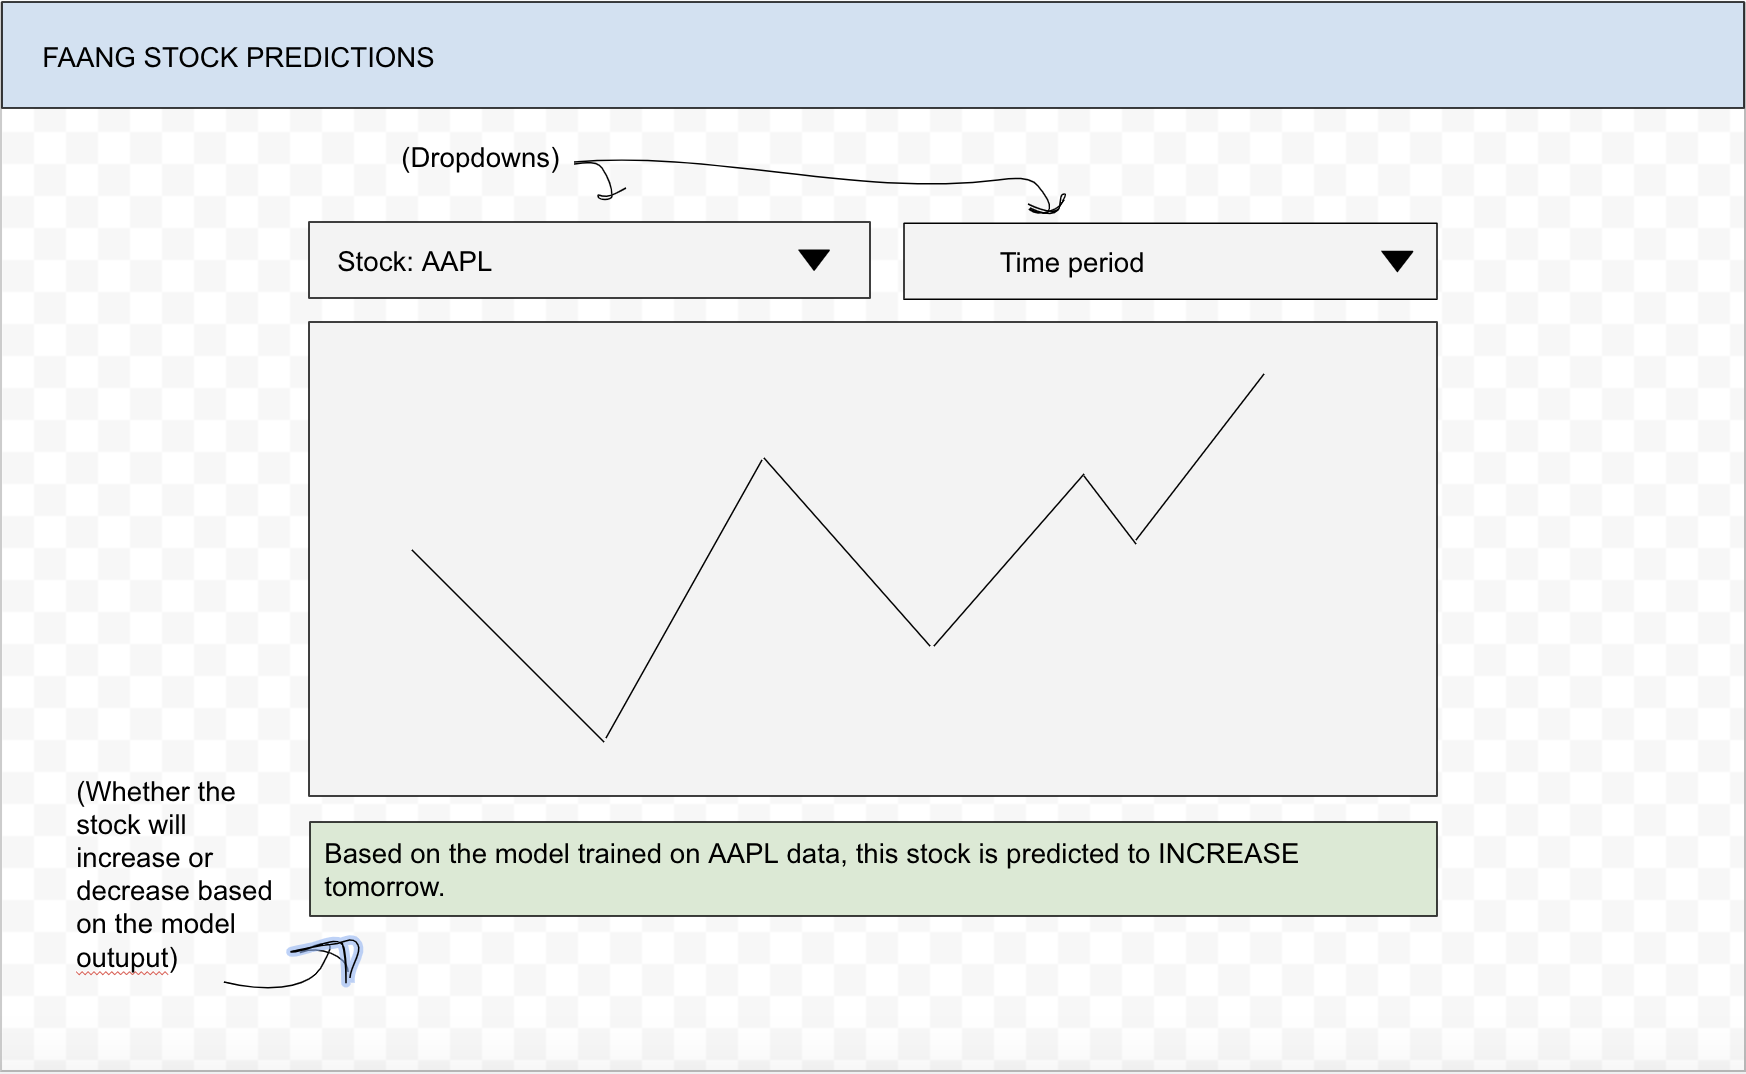

# Introduction

## Abstract


*   Used an MLP to create a model to predict whether a security would be higher or lower some *n* days ahead
*   The best model (365 days ahead) was able to achieve approximately 92% accuracy
*   Made predictions on Index Funds (VFIAX) with data from 'yfinance' library
*   To add more information we also added in FRED data (unemployment data)



## Data

In [ ]:
# An S & P 500 Index Fund
VFIAX = yf.Ticker('VFIAX')
VFIAX = pd.DataFrame(VFIAX.history(period="max")).reset_index()
VFIAX.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-11-13,86.776405,86.776405,86.776405,86.776405,0,0.0,0
1,2000-11-14,88.819359,88.819359,88.819359,88.819359,0,0.0,0
2,2000-11-15,89.271049,89.271049,89.271049,89.271049,0,0.0,0
3,2000-11-16,88.152275,88.152275,88.152275,88.152275,0,0.0,0
4,2000-11-17,87.860420,87.860420,87.860420,87.860420,0,0.0,0


In [ ]:
fred = Fred(api_key='578a1c037941def9766fc272c187336b')
pd.Series(fred.get_series_latest_release('UNRATE'))

1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
             ... 
2020-12-01    6.7
2021-01-01    6.3
2021-02-01    6.2
2021-03-01    6.0
2021-04-01    6.1
Length: 880, dtype: float64

## Exploratory analysis

In [ ]:
# This cell will not work if re-run. It uses a function defined lower down, and was moved from a cell below that function.
#
# data = clean_stock_data_binary_target(VFIAX, 365, add_macro_indicators=True, boost=False).reset_index(drop=True)
# plt.figure() # Push new figure on stack
# sns_plot = sns.pairplot(data.drop(['Day', 'Month'], axis=1), hue="Target")
# plt.savefig('MLStocksPairPlotNoDayNoMonth.png') # Save that figure

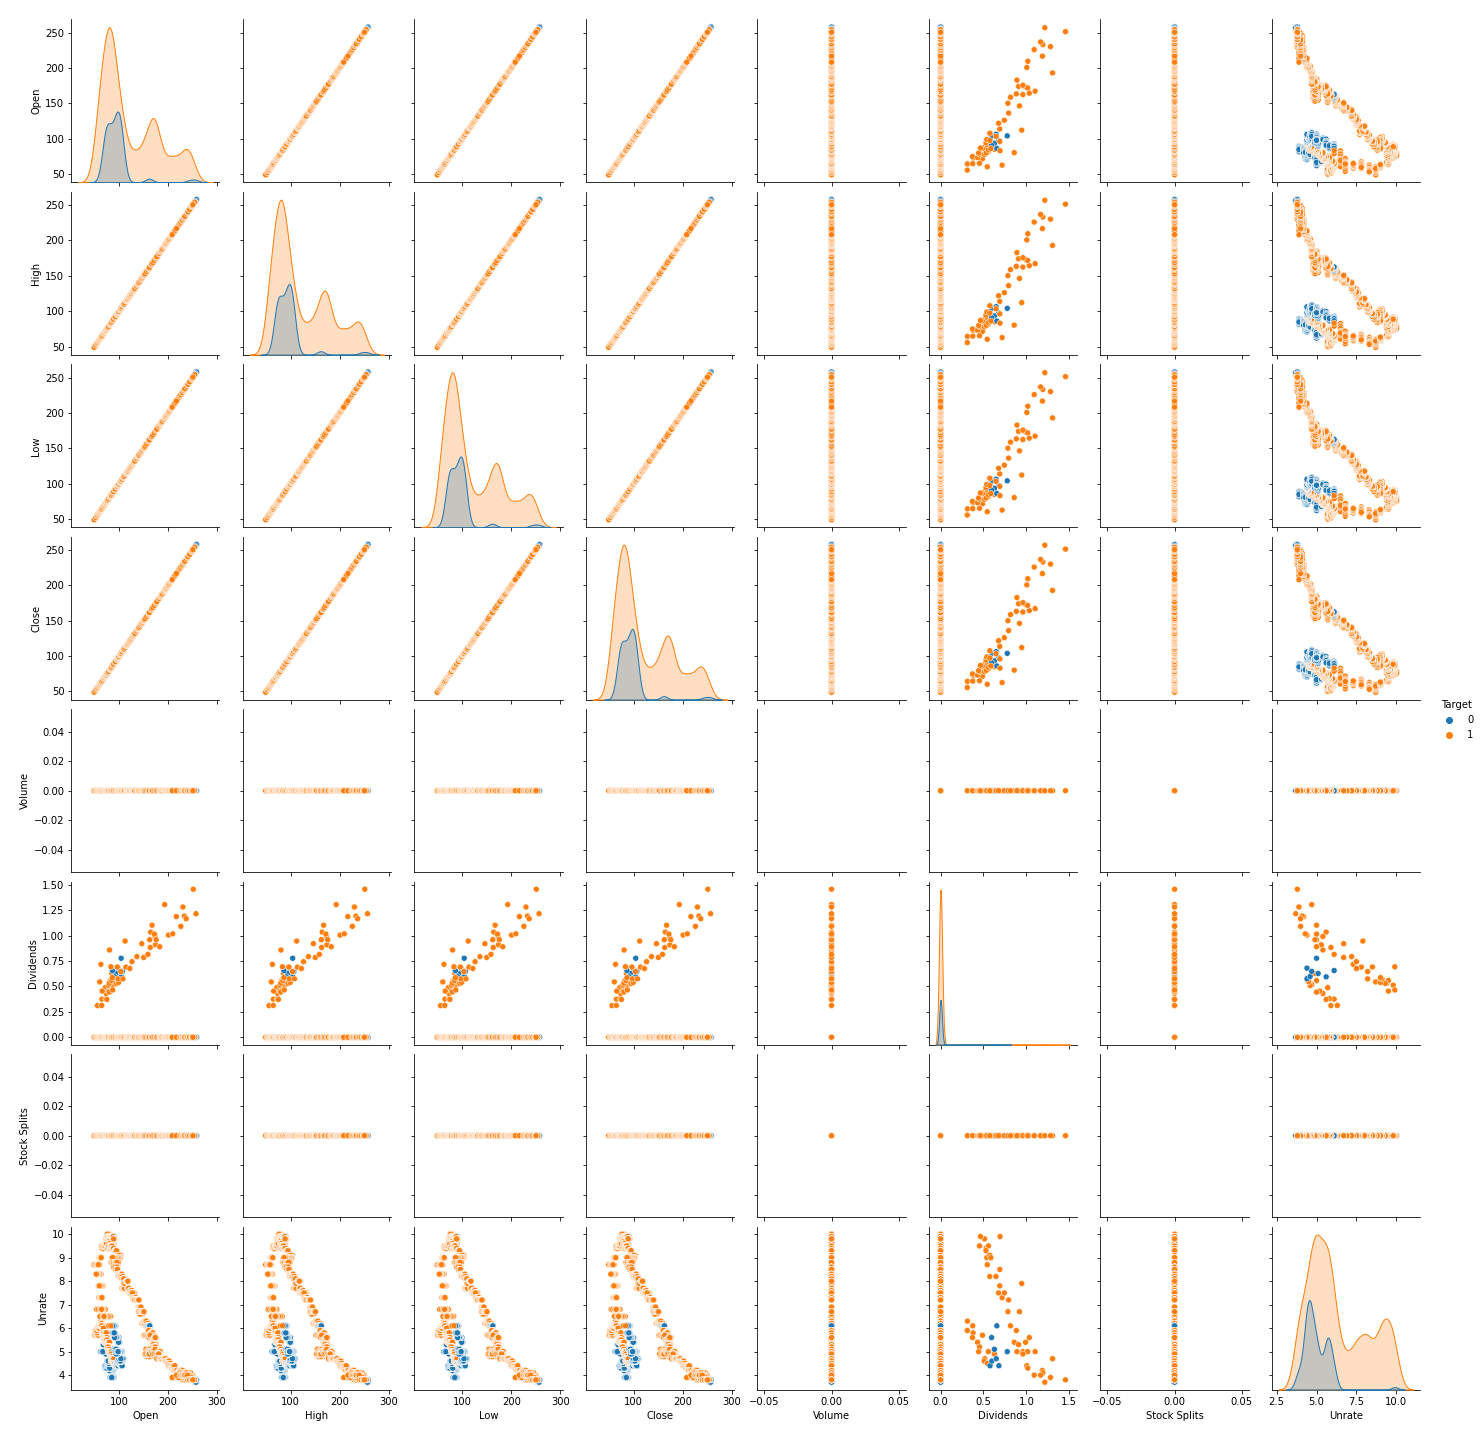

# Training (data cleaning, model building)

## Data cleaning and enhancements



**NOTE:** The more variance in any of these proposed features, the more information in them, and therefore the more helpful they will be. If an indicator simply always goes up, it's probably not useful (ex: GDP).

**NOTE:** Can take multiple approaches to adding these features. One approach could be binary classification of if the indicator has been increasing in recent past, or can just use the plain number, etc.

Possible macroeconomic features to add:
- GDP (https://fred.stlouisfed.org/series/GDP, *very low variance*)
- Retail sales (https://fred.stlouisfed.org/series/RSXFS, *mid-low variance*)
- Industrial production (https://fred.stlouisfed.org/series/INDPRO, *medium variance*)
- Employment data (Unemployment rate: https://fred.stlouisfed.org/series/UNRATE, *high variance*) [✅ added, pulls from CSV on Github, not real-time]
- Consumer price index, inflation (https://fred.stlouisfed.org/series/CPIAUCSL, *low variance*)


Possible company-specific data to add:
- Financial accounting data (figures from P/L statement, balance sheet, ...)
- Ratio of the company's stock price to the actual assets of the company

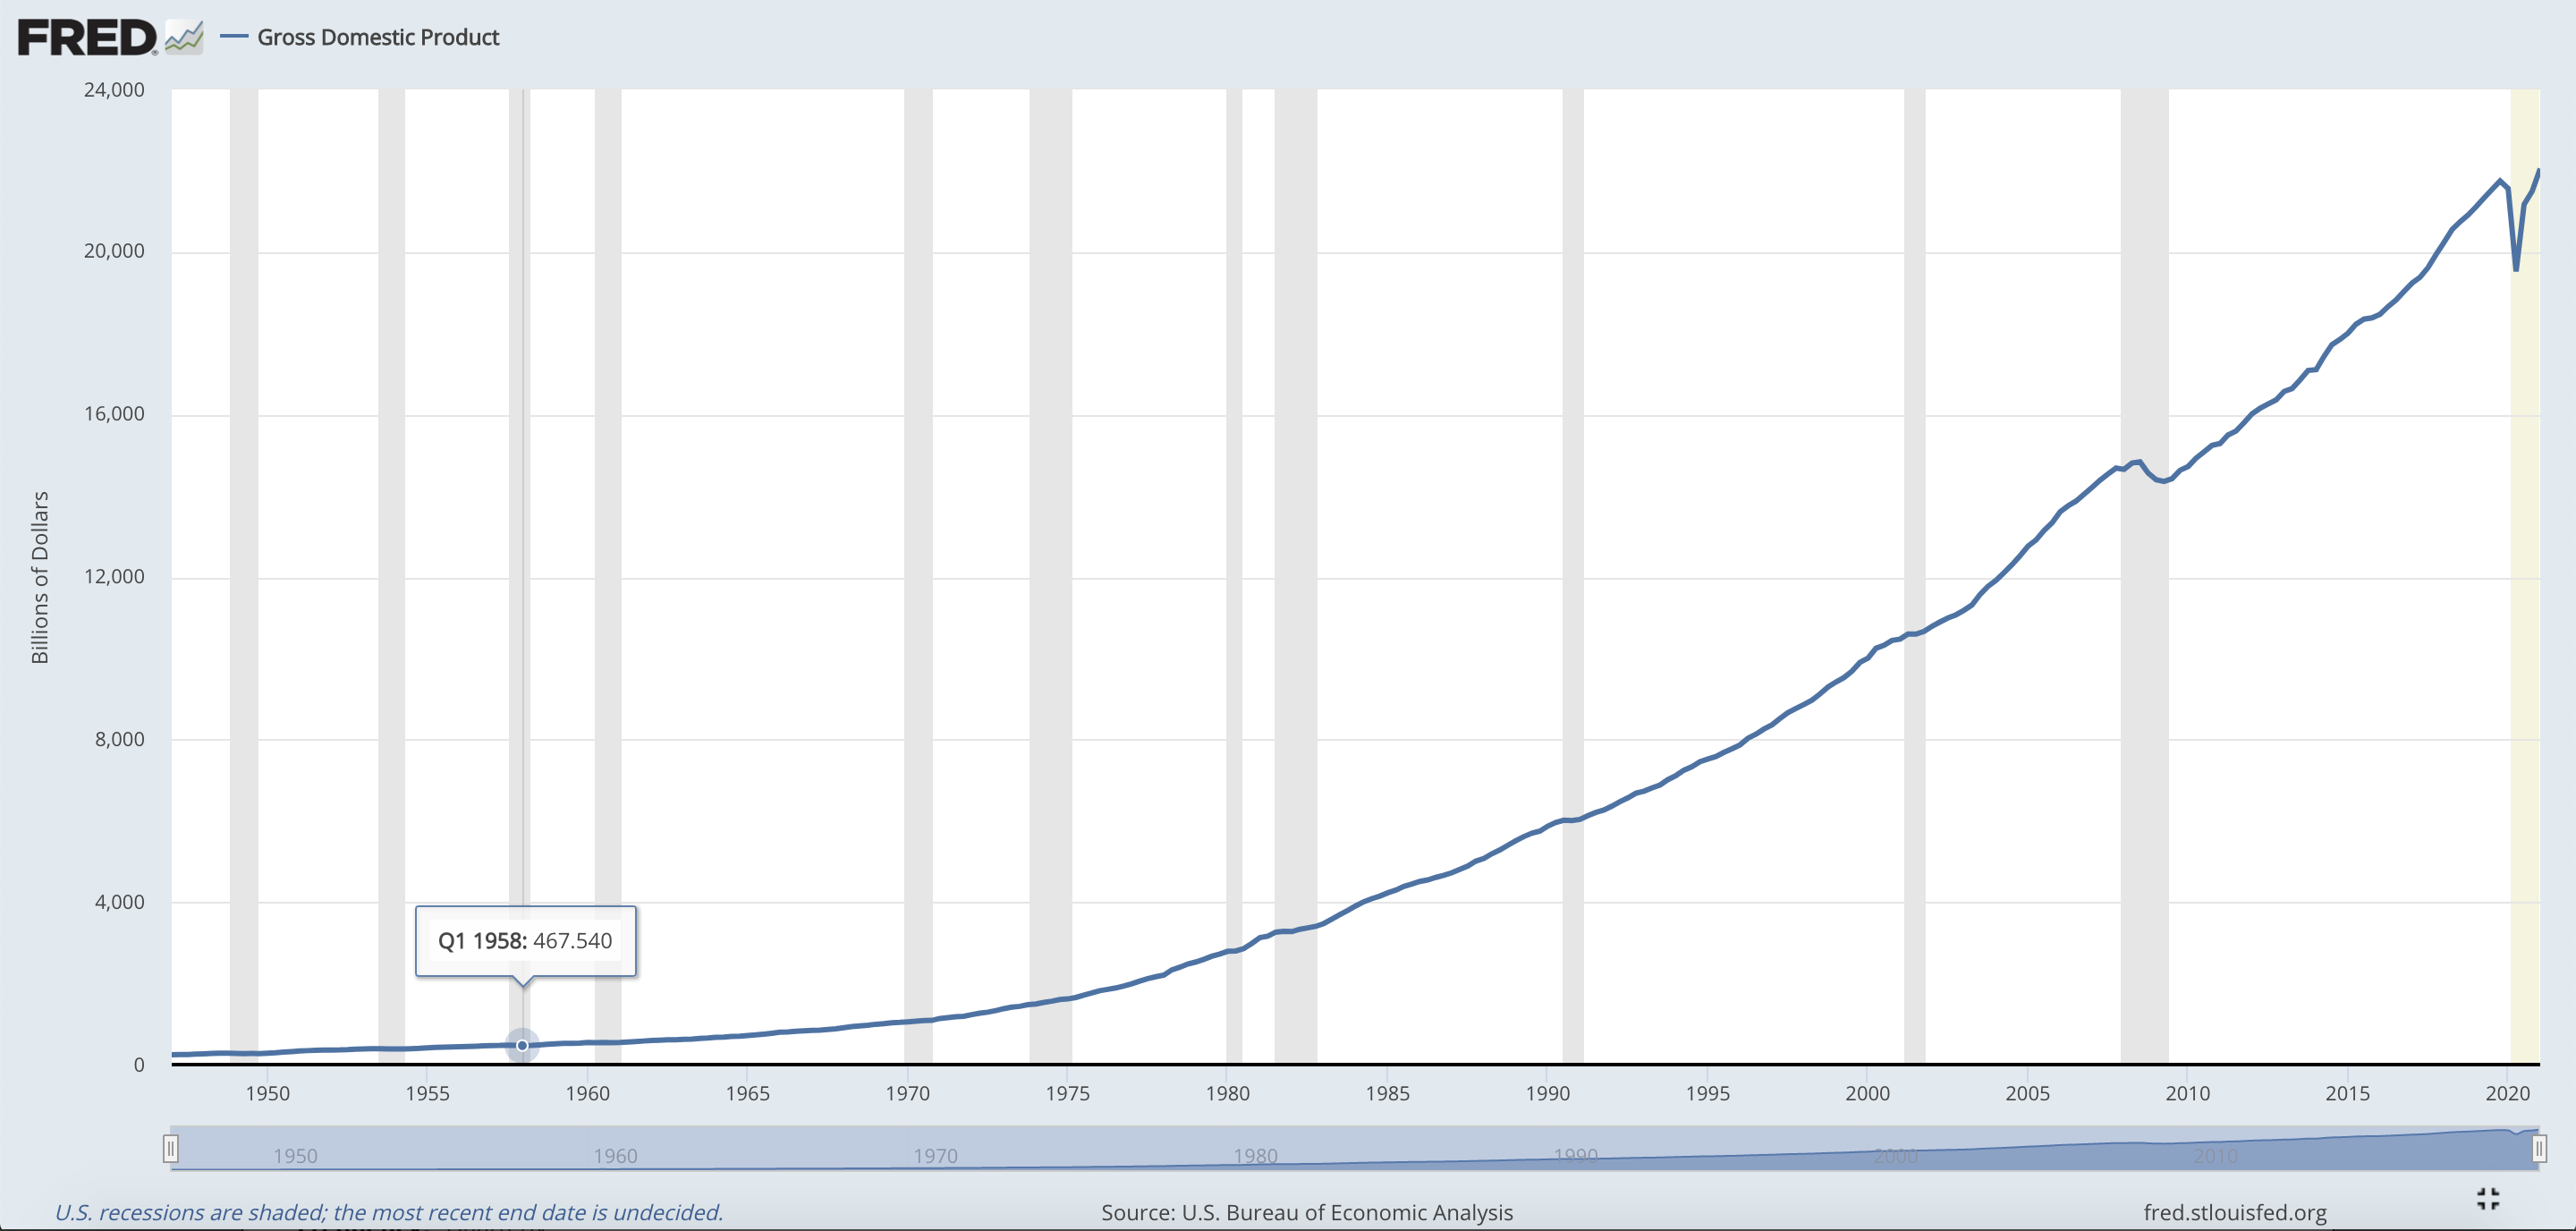

Graph of gross domestic product (GDP) over time.

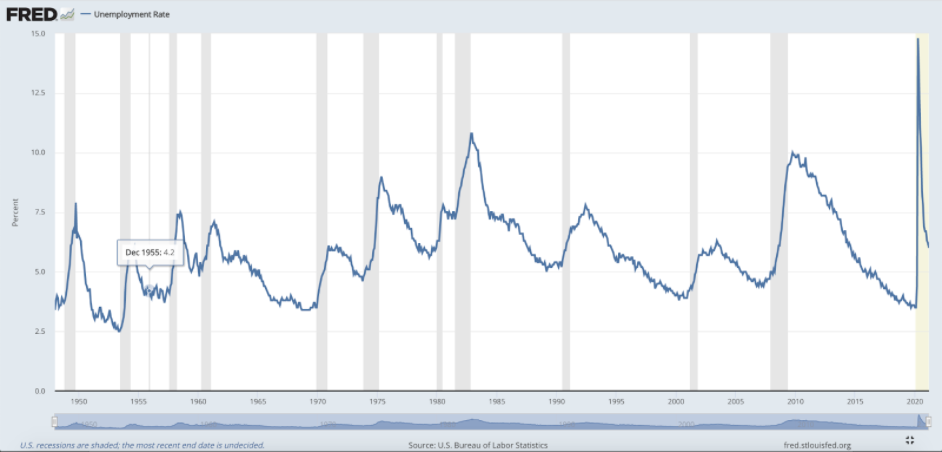

Graph of unemployment rate over time.

In [ ]:
def clean_and_train_test_split(stock_df, n_days_ahead=7, add_macro_indicators=False, boost=False, binary=True):
  """
  Convenience method.
  Uses the cleaning method to clean the data set and then does a train test split.
  """
  if binary:
    stock_proper = clean_stock_data_binary_target(stock_df, n_days_ahead, add_macro_indicators=add_macro_indicators, boost=boost) # NOTE: Upgraded this method (and changed the name) to add data on Unemployment to the df.

    # print(f"Proportion of 0s: {stock_proper['Target'].value_counts()[0]/len(stock_proper.Target)}\n")
    # print(f"Proportion of 1s: {stock_proper['Target'].value_counts()[1]/len(stock_proper.Target)}\n")


  else:
    stock_proper = add_target_stock_outcome_regression(stock_df, n_days_ahead)

  X_full = stock_proper.drop('Target', axis=1)
  y_full = stock_proper['Target']

  X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.30)

  prop_0s = len(y_full[y_full == 0]) / len(y_full)
  prop_1s = len(y_full[y_full == 1]) / len(y_full)

  return X_train, X_test, y_train, y_test, prop_0s, prop_1s

In [ ]:
# Add a binary target column, whether a stock goes up N days ahead or not.

def clean_stock_data_binary_target(stock_data_df, n_days_ahead=1, add_macro_indicators=False, boost=False):
  """
  Takes a stock's historical data dataframe as input and returns
  a dataframe with target column added and economic indicators
  (when add_macro... = True) and the. The target column is either
  1 or 0, to denote if the stock's price was higher or lower on
  n_days_ahead of each row/day.

  :add_macro_indicators - Adds macroeconomic indicators gathered from FRED database as features when True.

  :boost - Evens out the occurences of each category.
  """

  # Iterate over all rows in stock df and build target column.
  target_column = []
  for index, row in stock_data_df.iterrows():
    # If the row/day has enough rows/days following it, do normal assignment, else, set target to NULL
    if index < (len(stock_data_df) - n_days_ahead):
      # If the price of day corresponding to stock_data_df.iloc[counter + n_days_ahead]
      # is higher than the current row's price, append 1 to target column, else append 0.
      if stock_data_df.iloc[index + n_days_ahead]['Close'] > row['Close']:
        target_column.append(1)
      else:
        target_column.append(0)
    else:
      target_column.append(None)


  # The last rows in the data set cannot be used, because there is no data ahead of them
  # to use to check if the price increased or not.
  n = -1 * (n_days_ahead)
  trimmed_stock_data_df = stock_data_df[:n]
  trimmed_target_column = pd.DataFrame(target_column[:n], columns=['Target'])


  # Boost the data, a.k.a. make certain that both categories appear equally as often in data set.

  # Add the target column temporarily for boosting, then save the target column after boosting before removing it.
  if boost:
    temp_target_added = trimmed_stock_data_df.reset_index(drop=True).join(trimmed_target_column.reset_index(drop=True), how='left')

    # print("N ROWS TOTAL =", len(temp_target_added))

    # Add enough instances of less frequent class to even out the frequencies of 0 and 1.
    higher_frequency_class = 0 if len(temp_target_added.Target[temp_target_added.Target == 0]) > len(temp_target_added.Target[temp_target_added.Target == 1]) else 1
    lower_frequency_class = 1 if higher_frequency_class is 0 else 0

    len_higher_freq = len((temp_target_added.Target[temp_target_added.Target == higher_frequency_class]))
    len_lower_freq = len((temp_target_added.Target[temp_target_added.Target == lower_frequency_class]))

    # print("LOW FREQ. =", )
    # print("HIGH FREQ. =", len((temp_target_added.Target[temp_target_added.Target == lower_frequency_class])))

    difference = len_higher_freq - len_lower_freq
    # print("DIFFERENCE =", difference)

    # Sample <difference> rows from lower frequency class and add them to the data set.
    if difference < len_lower_freq:
      sample_of_less_frequent = temp_target_added[temp_target_added['Target'] == lower_frequency_class].sample(n=difference)

    else: # Replacement necessary b/c not enough samples of less frequent class to make up for difference.
      sample_of_less_frequent = temp_target_added[temp_target_added['Target'] == lower_frequency_class].sample(n=difference, replace=True)

    temp_target_added = temp_target_added.append(sample_of_less_frequent).reset_index()

    temp_target_added = temp_target_added.sort_values(by='Date')

    trimmed_target_column = temp_target_added['Target']

    trimmed_stock_data_df = temp_target_added.drop('Target', axis=1)


  # Re-engineer the date column. Cannot use datetime objects, but can use # month, # day.
  # Year is probably not useful, since new predictions will be made on current year not
  # past.
  # -- Create day and month columns
  n_month_col = [dt.month for dt in trimmed_stock_data_df['Date']]
  n_day_col = [dt.day for dt in trimmed_stock_data_df['Date']]
  n_year_col = [dt.year for dt in trimmed_stock_data_df['Date']] # WARNING: Not added to final data frame, just used to query economic indicators.


  # Add economic indicators (unemployemnt rate).
  if add_macro_indicators:

    unemployment_rate = pd.read_csv('https://raw.githubusercontent.com/Brennan-Richards/public-data-sets/main/UNRATE.csv') # Unemployment rate data, .csv stored in Github

    # Clean unemployment data
    unemployment_rate['DATE'] = unemployment_rate['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

    # Add month/year columns to unemployment data for easy querying.
    unrate_n_month_col = [int(dt.month) for dt in unemployment_rate['DATE']]
    unrate_n_year_col = [int(dt.year) for dt in unemployment_rate['DATE']]
    unemployment_rate = unemployment_rate.reset_index(drop=True).join(pd.DataFrame(unrate_n_month_col, columns=['Month']).reset_index(drop=True), how='left')
    unemployment_rate = unemployment_rate.reset_index(drop=True).join(pd.DataFrame(unrate_n_year_col, columns=['Year']).reset_index(drop=True), how='left')

    # Remove elements from n_month_col and n_year_col where no data from economic indicators
    n_popped = 1 # Stores number of rows of stock data without corresponding economic indicators.

    latest_month = n_month_col.pop()
    while latest_month > unrate_n_month_col[-1]:
      latest_month = n_month_col.pop()
      n_popped += 1

    latest_year = n_year_col.pop()
    while latest_year > unrate_n_year_col[-1]:
      latest_year = n_year_col.pop()

    trimmed_stock_data_df = trimmed_stock_data_df[:(-1 * n_popped)]

    # Build an unemployment rate column where the value is the unemployment rate of
    # the month & year of every row in the stock dataframe.
    unemployment_rate_col = pd.DataFrame([ unemployment_rate[(unemployment_rate.Month == int(month)) & (unemployment_rate.Year == int(year))]['UNRATE'].values[0] for (month, year) in zip(n_month_col, n_year_col)], columns=["Unrate"])

    # Join unemployment rate column with trimmed data frame.
    trimmed_stock_data_df = trimmed_stock_data_df.reset_index(drop=True).join(unemployment_rate_col.reset_index(drop=True), how='left')

  # Join trimmed df with day and month columns
  trimmed_stock_data_df = trimmed_stock_data_df.reset_index(drop=True).join(pd.DataFrame(n_month_col, columns=['Month']).reset_index(drop=True), how='left')
  trimmed_stock_data_df = trimmed_stock_data_df.reset_index(drop=True).join(pd.DataFrame(n_day_col, columns=['Day']).reset_index(drop=True), how='left')
  # Remove unusable date column.
  trimmed_stock_data_df = trimmed_stock_data_df.drop('Date', axis=1)

  # Add the target column
  # Create a new df that looks like [trimmed_stock_data_df | trimmed_target_column]
  cleaned_stock_data_df_w_target = trimmed_stock_data_df.reset_index(drop=True).join(trimmed_target_column.reset_index(drop=True), how='left')

  return cleaned_stock_data_df_w_target

## Methods for model building

In [ ]:
def classification_confint(acc, n):
    '''
    Compute the 95% confidence interval for a classification problem.
      acc -- classification accuracy
      n   -- number of observations used to compute the accuracy
    Returns a tuple (lb,ub)
    '''
    import math
    interval = 1.96*math.sqrt(acc*(1-acc)/n)
    lb = round(max(0, acc - interval), 3)
    ub = round(min(1.0, acc + interval), 3)
    return (lb,ub)

In [ ]:
# Data from training/test method below accumulates here.

cumulative_data = {
    'ticker':[],
    'n_days_ahead':[],
    'hidden_layer_sizes':[],
    'activation':[],
    'learning_rate':[],
    'solver':[],
    'macro_indicators':[],
    'accuracy':[],
    'confidence_interval':[],

    # Track proportions of 1s and proportions of 0s
    # to make sure model is performing better than just
    # predicting 0 or 1.
    'prop_0s':[],
    'prop_1s':[],

    # Guessed 0 correctly, and so on...
    'G0C':[],
    'G0I':[],
    'G1C':[],
    'G1I':[],

    'F1':[]
}

# Array for saving the best estimator of each grid search.
save_best_estimators = []

# Save the predictions of the best estimator from each grid search.
save_predictions = []


# Train model with a grid search over parameters

def grid_search_train_mlp_classifier(stock_ticker, param_grid_options, n_days_ahead=7, add_macro_indicators=False, boost=False, binary=True):

  """
  End-to-end method for training an MLP Classifier model tailored to our specific use-case.
  - Retrieves data
  - Cleans and does a train/test split using methods from above.
  - Runs a grid search.
  - Computes metrics such as the test accuracy score, F1/confusion matrix, confidence interval.
  - Stores the parameters and metrics in the cumulative_data dictionary.
  """

  # Create dataframe of stock data.
  stock_data = yf.Ticker(stock_ticker)
  stock_df = pd.DataFrame(stock_data.history(period="max")).reset_index()

  # Train/test split and retrieve proportion of 0s and 1s from target.
  X_train, X_test, y_train, y_test, prop_0s, prop_1s = clean_and_train_test_split(stock_df, n_days_ahead=n_days_ahead, add_macro_indicators=add_macro_indicators, boost=boost, binary=binary)
  cumulative_data['prop_0s'].append(prop_0s)
  cumulative_data['prop_1s'].append(prop_1s)


  param_grid = param_grid_options

  # if solver is not None:
  #   param_grid['solver'] = solver

  # if learning_rate is not None:
  #   param_grid['learning_rate'] = learning_rate

  # if activation is not None:
  #   param_grid['activation'] = activation

  # if hidden_layer_params is not None:
  #   param_grid['hidden_layer_sizes'] = hidden_layer_params

  model = MLPClassifier()

  grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

  grid.fit(X_train, y_train)

  # print("Grid Search: best parameters: {}".format(grid.best_params_))

  # Test binary classification model

  # Get accuracy of best model with confidence interval
  best_model = grid.best_estimator_
  save_best_estimators.append(best_model)

  predictions = best_model.predict(X_test)
  save_predictions.append(predictions)

  # Compute metrics of this model
  acc = accuracy_score(y_test, predictions)
  lb,ub = classification_confint(acc,X_test.shape[0])
  cm = confusion_matrix(y_test, predictions)

  # Store data from test in the cumulative dataframe

  # -- Basic data
  cumulative_data['ticker'].append(stock_ticker)
  cumulative_data['n_days_ahead'].append(n_days_ahead)

  # -- Parameter data
  hidden_layer_sizes = grid.best_params_['hidden_layer_sizes'] if 'hidden_layer_sizes' in grid.best_params_ else (100,)
  cumulative_data['hidden_layer_sizes'].append(str(hidden_layer_sizes))

  activation = grid.best_params_['activation'] if 'activation' in grid.best_params_ else 'relu'
  cumulative_data['activation'].append(activation)

  learning_rate = grid.best_params_['learning_rate'] if 'learning_rate' in grid.best_params_ else 'constant'
  cumulative_data['learning_rate'].append(learning_rate)

  solver = grid.best_params_['solver'] if 'solver' in grid.best_params_ else 'adam'
  cumulative_data['solver'].append(solver)

  cumulative_data['macro_indicators'].append(add_macro_indicators)

  cumulative_data['accuracy'].append(acc)

  cumulative_data['confidence_interval'].append(str((lb, ub)))

  # -- Confusion matrix/F1 data.
  cumulative_data['G0C'].append(cm[0][0])
  cumulative_data['G0I'].append(cm[1][0])
  cumulative_data['G1C'].append(cm[1][1])
  cumulative_data['G1I'].append(cm[0][1])
  cumulative_data['F1'].append(f1_score(y_test, predictions))

  return cumulative_data # pd.DataFrame(cumulative_data, columns=[k for k in cumulative_data.keys()])

In [ ]:
# Training one model for each calendar period on SPX data.

hidden_layer_sizes = [11, 21]

hidden_layer_params = [(i,) for i in hidden_layer_sizes] + [(i - 5, i) for i in hidden_layer_sizes] + [(i - 5, i, i - 5) for i in hidden_layer_sizes]

param_grid_options = {
    'hidden_layer_sizes': hidden_layer_params,
    'activation': ['relu']
}

for time_period in [1, 7, 14, 30, 365]:
  grid_search_train_mlp_classifier(stock_ticker='VFIAX', param_grid_options=param_grid_options, n_days_ahead=time_period, add_macro_indicators=True, boost=True)

In [ ]:
pd.DataFrame(cumulative_data, columns=[k for k in cumulative_data.keys()])

,ticker,n_days_ahead,hidden_layer_sizes,activation,learning_rate,solver,macro_indicators,accuracy,confidence_interval,prop_0s,prop_1s,G0C,G0I,G1C,G1I,F1
0,VFIAX,1,"(6, 11, 6)",relu,constant,adam,True,0.511084,"(0.487, 0.535)",0.500270,0.499730,182,190,671,626,0.621872
1,VFIAX,7,"(6, 11, 6)",relu,constant,adam,True,0.514457,"(0.492, 0.537)",0.500900,0.499100,503,454,440,436,0.497175
2,VFIAX,14,"(16, 21, 16)",relu,constant,adam,True,0.530015,"(0.508, 0.552)",0.500693,0.499307,468,378,565,538,0.552297
3,VFIAX,30,"(6, 11, 6)",relu,constant,adam,True,0.560139,"(0.538, 0.582)",0.500075,0.499925,213,75,914,810,0.673793
4,VFIAX,365,"(16, 21, 16)",relu,constant,adam,True,0.927543,"(0.917, 0.938)",0.510872,0.489128,1071,98,1054,68,0.927001


# Results

**IMPORTANT:** Note that our **best model's F1 score** on predicting whether the VFIAX index fund will increase or decrease in 365 days time **is 92%**.

# Conclusions



*   Given the best model's performance of 92%, this project can be considered a success
*   The model seems to give an investor much better odds than random chance. It can tip investors off as to when it may not be a good idea to invest their money (in the VFIAX S&P 500 index fund)
*   We believe that this hypothesis is worth investigating, and we outline some methods for testing this hypothesis in the future work section of the appendix below.

# Appendix

## User Interface

The parameters for the highest performing model can be frozen and served from a cloud endpoint, and a user interface can be constructed atop that predictive capability to further enable investors. Here is a prototype for said UI.

In [ ]:
# Model persistance with sklearn's joblib extension.

best_model_365 = save_best_estimators[4]
dump(best_model_365, 'VFIAX_one_year.joblib')

['VFIAX_one_year.joblib']




*   Best model made **persistent** using sklearn's joblib extension
*   Application runs on a server and makes predictions at scheduled intervals (each night at market close) about the price of VFIAX a year away
*   Retrieves the latest market data from APIs in order to make prediction




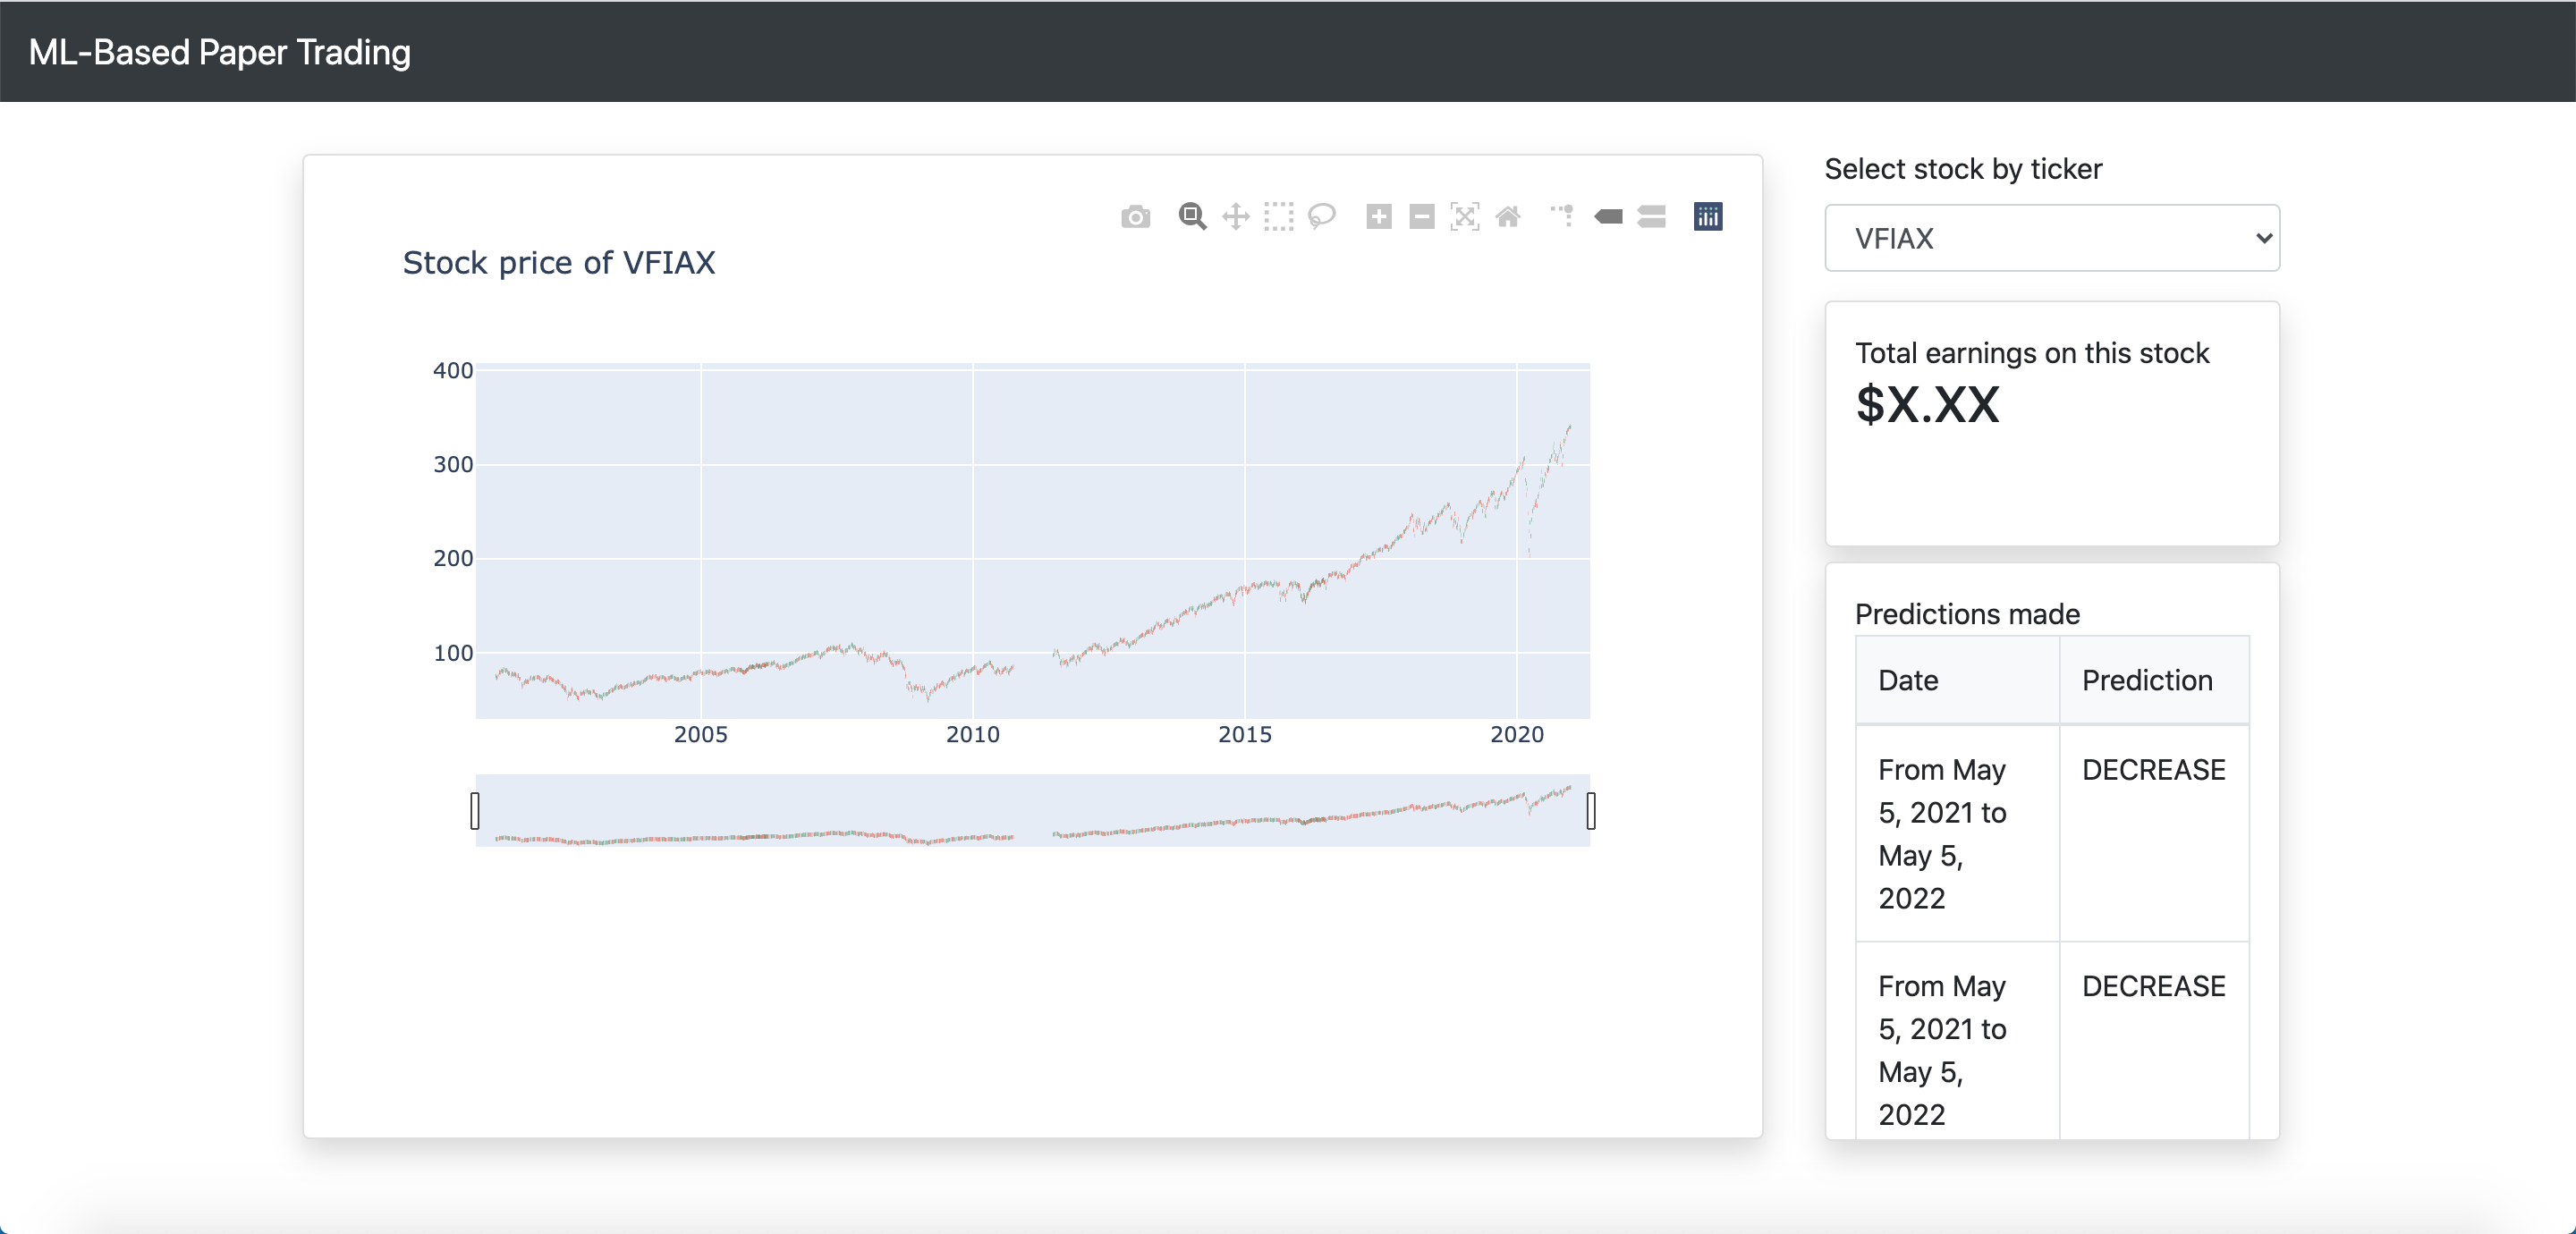

A user interface, which incorporates the persistent models.

## Directions of future effort

### Integrating real stock trading



*   Use a package such as [Alpaca](https://alpaca.markets) which has very nice integrations for developers, and specifically Python
*   Tie into our web application + user interface



### More features

Possible macroeconomic features to add:
- **GDP** (https://fred.stlouisfed.org/series/GDP)
- **Retail sales** (https://fred.stlouisfed.org/series/RSXFS)
- **Industrial production** (https://fred.stlouisfed.org/series/INDPRO)
- **Unemployment rate** (https://fred.stlouisfed.org/series/UNRATE)
- **Consumer price index, inflation** (https://fred.stlouisfed.org/series/CPIAUCSL)


### Deeper neural networks



*   Use a package like *pytorch* to create deeper neural network model
*   We believe this would improve performance



### Regression prediction models




*   Useful, if high accuracy, because instead of just predicting whether a stock will go up or down, we can predict by how much it will rise/fall.
*   We started to do this (below) before settling on binary classification because the intial performance on binary classification was superior.





In [ ]:
def regression_confint(rs_score, n, k):
    '''
    Compute the 95% confidence interval for a regression problem.
      rs_score -- R^2 score
      n        -- number of observations used to compute the R^2 score
      k        -- number of independent variables in dataset
    Returns a tuple (lb,ub)

    Reference:
    https://books.google.com/books?id=gkalyqTMXNEC&pg=PA88#v=onepage&q&f=false
    '''
    import math
    interval = 2*math.sqrt((4*rs_score*(1-rs_score)**2*(n-k-1)**2)/((n**2 - 1)*(n+3)))
    lb = max(0, rs_score - interval)
    ub = min(1.0, rs_score + interval)
    return (lb,ub)

In [ ]:
# Add a regression target column, the slope between the price on each day and
# on the day N days ahead of it.

def add_target_stock_outcome_regression(stock_data_df, n_days_ahead=1):
  """
  Takes a stock's historical data dataframe as input and returns
  a dataframe with the target column added. The target column is
  the slope between the current day's price and the price on the
  day n_days_ahead of it.
  """

  # Iterate over all rows in stock df and build target column.
  target_column = []

  for index, row in stock_data_df.iterrows():
    # If the row/day has enough rows/days following it, do normal assignment, else, set target to NULL
    if index < (len(stock_data_df) - n_days_ahead):
      # Calculate change in Y / change in X - where change in X is n_days_ahead, and change in Y
      # is the change in price from starting day to n_days_ahead.
      change_y = stock_data_df.iloc[index + n_days_ahead]['Close'] - row['Close']
      change_x = n_days_ahead
      slope = change_y / change_x
      target_column.append(slope)
    else:
      target_column.append(None)

  # The last rows in the data set cannot be used, because there is no data ahead of them
  # to use to check if the price increased or not.
  n = -1 * (n_days_ahead)
  trimmed_stock_data_df = stock_data_df[:n]
  trimmed_target_column = pd.DataFrame(target_column[:n], columns=['Target'])

  # Re-engineer the date column. Cannot use datetime objects, but can use # month, # day.
  # Year is probably not useful, since new predictions will be made on current year not
  # past.
  # -- Create day and month columns
  n_month_col = pd.DataFrame([dt.month for dt in trimmed_stock_data_df['Date']], columns=['Month'])
  n_day_col = pd.DataFrame([dt.day for dt in trimmed_stock_data_df['Date']], columns=['Day'])
  # -- Join trimmed df with day and month columns
  trimmed_stock_data_df = trimmed_stock_data_df.reset_index(drop=True).join(n_month_col.reset_index(drop=True), how='left')
  trimmed_stock_data_df = trimmed_stock_data_df.reset_index(drop=True).join(n_day_col.reset_index(drop=True), how='left')
  # -- Remove unusable date column.
  trimmed_stock_data_df = trimmed_stock_data_df.drop('Date', axis=1)

  # Create a new df that looks like [trimmed_stock_data_df | trimmed_target_column]
  cleaned_stock_data_df_w_target = trimmed_stock_data_df.reset_index(drop=True).join(trimmed_target_column.reset_index(drop=True), how='left')

  # print(target_column)
  # print(trimmed_stock_data_df)

  return cleaned_stock_data_df_w_target

add_target_stock_outcome_regression(tsla, 2)

In [ ]:
# Train/test split

tsla_proper = add_target_stock_outcome_regression(tsla, 1)

X_full = tsla_proper.drop('Target', axis=1)
y_full = tsla_proper['Target']

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.30)

In [ ]:
# Train regression model with a grid search over parameters

hidden_layer_params = [(i,) for i in range(10,21)] + [(i, 10) for i in range(10,21)]

param_grid = {'activation': ['relu', 'logistic', 'tanh', 'identity'],
              'hidden_layer_sizes': hidden_layer_params,
              }

model = MLPRegressor()

grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid.fit(X_train, y_train)

print("Grid Search: best parameters: {}".format(grid.best_params_))

Grid Search: best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (20,)}


In [ ]:
len(X_test.columns)

9

In [ ]:
# Test regression model

# Get accuracy of best model with confidence interval
best_model = grid.best_estimator_

predictions = best_model.predict(X_test)

r2 = r2_score(y_test, predictions)

# NOTE: These cells commented out because running regression_confint when
# r^2 negative raises an error.

# lb,ub = regression_confint(r2, X_test.shape[0], k=len(X_test.columns))

# print("R^2: {:3.2f} ({:3.2f},{:3.2f})".format(r2,lb,ub))

print(r2)

-0.0022554724412870986
